### correlation file info 
### [0] is an image object? 
### [1] is data table 
### with this header: 
"""
XTENSION= 'BINTABLE' / FITS Binary Table Extension                              
BITPIX  =                    8 / 8-bits character format                        
NAXIS   =                    2 / Tables are 2-D char. array                     
NAXIS1  =                   88 / Bytes in row                                   
NAXIS2  =                  428 / no comment                                     
PCOUNT  =                    0 / Parameter count always 0                       
GCOUNT  =                    1 / Group count always 1                           
TFIELDS =                   13 / No. of col in table                            
TFORM1  = '1D      ' / Format of field                                          
TTYPE1  = 'field_x ' / Field label                                              
TUNIT1  = 'pixels  ' / Physical unit of field                                   
TFORM2  = '1D      ' / Format of field                                          
TTYPE2  = 'field_y ' / Field label                                              
TUNIT2  = 'pixels  ' / Physical unit of field                                   
TFORM3  = '1D      ' / Format of field                                          
TTYPE3  = 'field_ra' / Field label                                              
TUNIT3  = 'degrees ' / Physical unit of field                                   
TFORM4  = '1D      ' / Format of field                                          
TTYPE4  = 'field_dec' / Field label                                             
TUNIT4  = 'degrees ' / Physical unit of field                                   
TFORM5  = '1D      ' / Format of field                                          
TTYPE5  = 'index_x ' / Field label                                              
TUNIT5  = 'pixels  ' / Physical unit of field                                   
TFORM6  = '1D      ' / Format of field                                          
TTYPE6  = 'index_y ' / Field label                                              
TUNIT6  = 'pixels  ' / Physical unit of field                                   
TFORM7  = '1D      ' / Format of field                                          
TTYPE7  = 'index_ra' / Field label                                              
TUNIT7  = 'degrees ' / Physical unit of field                                   
TFORM8  = '1D      ' / Format of field                                          
TTYPE8  = 'index_dec' / Field label                                             
TUNIT8  = 'degrees ' / Physical unit of field                                   
TFORM9  = '1J      ' / Format of field                                          
TTYPE9  = 'index_id' / Field label                                              
TUNIT9  = 'none    ' / Physical unit of field                                   
TFORM10 = '1J      ' / Format of field                                          
TTYPE10 = 'field_id' / Field label                                              
TUNIT10 = 'none    ' / Physical unit of field                                   
TFORM11 = '1D      ' / Format of field                                          
TTYPE11 = 'match_weight' / Field label                                          
TUNIT11 = 'none    ' / Physical unit of field                                   
TFORM12 = '1E      ' / Format of field                                          
TTYPE12 = 'FLUX    ' / Field label                                              
TFORM13 = '1E      ' / Format of field                                          
TTYPE13 = 'BACKGROUND' / Field label                                            
ORIGIN  = 'ESO-QFITS' / Written by QFITS                                        
DATE    = '2023-12-07T21:16:23' / [UTC] Date of writing  
"""

In [18]:
from astropy.io import fits
from astropy.nddata import NDData
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils.psf import extract_stars, EPSFBuilder
import pandas as pd
import numpy as np
from compare_aspect.plots import centile_clip
import matplotlib.pyplot as plt 
import sys 
sys.path.append('/home/bekah/gPhoton2')
sys.path.append('/home/ubuntu/gPhoton2/gPhoton')
from gPhoton.pipeline import execute_pipeline

In [223]:
eclipse = 580
new_corr = fits.open(f'/home/bekah/glcat/corr_new_{eclipse}.fits')
old_corr = fits.open(f'/home/bekah/glcat/corr_old_{eclipse}.fits')
#old_corr = fits.open("/home/bekah/Downloads/corr.fits")

new_df=pd.DataFrame(np.array(new_corr[1].data).byteswap().newbyteorder())
old_df=pd.DataFrame(np.array(old_corr[1].data).byteswap().newbyteorder())

merged_corr = pd.merge(old_df, new_df, how='inner', on='index_id', suffixes=('_old', '_new'))

# calculate diff between star and index location 
merged_corr['old_ra_quality'] = abs(merged_corr['field_ra_old']-merged_corr['index_ra_old'])
merged_corr['old_dec_quality'] = abs(merged_corr['field_dec_old']-merged_corr['index_dec_old'])
merged_corr['new_ra_quality'] = abs(merged_corr['field_ra_new']-merged_corr['index_ra_new'])
merged_corr['new_dec_quality'] = abs(merged_corr['field_dec_new']-merged_corr['index_dec_new'])
merged_corr['flux_diff'] = merged_corr['FLUX_new']-merged_corr['FLUX_old']

In [224]:
merged_corr['index_ra_old']-merged_corr['index_ra_new']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
412    0.0
413    0.0
414    0.0
415    0.0
416    0.0
Length: 417, dtype: float64

Text(0.5, 1.0, 'flux_diff')

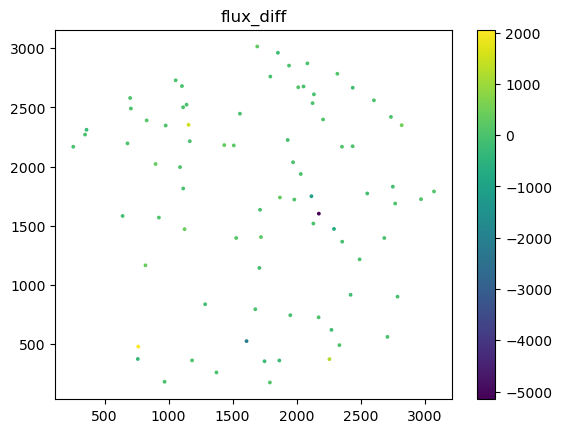

In [206]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['flux_diff'],s=3)

plt.colorbar()
plt.title("flux_diff")

Text(0.5, 1.0, 'old dec quality')

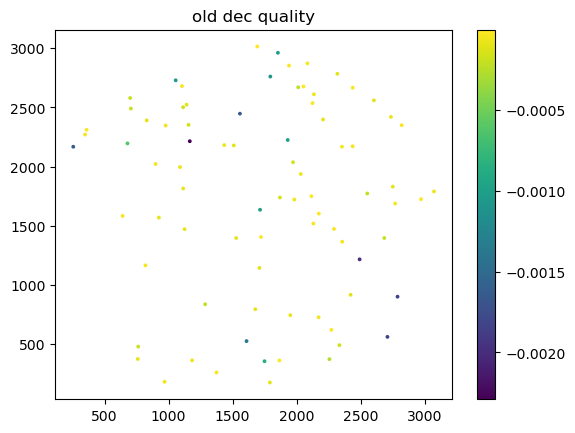

In [204]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['old_dec_quality'],s=3)

plt.colorbar()
plt.title('old dec quality')

Text(0.5, 1.0, 'new ra quality')

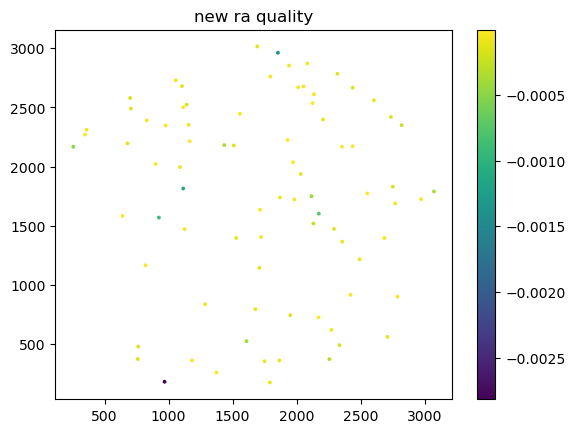

In [203]:
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['new_ra_quality'],s=3)
plt.colorbar()
plt.title("new ra quality")

Text(0.5, 1.0, 'old ra quality')

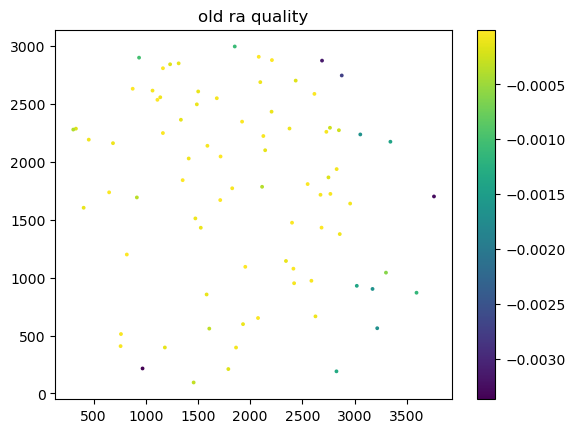

In [202]:
plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=-merged_corr['old_ra_quality'], s=3)
plt.colorbar()
plt.title("old ra quality")

(array([402.,  18.,   5.,   4.,   2.,   4.,   1.,   1.,   2.,   3.]),
 array([3.47269378e-08, 2.08558662e-04, 4.17082597e-04, 6.25606532e-04,
        8.34130467e-04, 1.04265440e-03, 1.25117834e-03, 1.45970227e-03,
        1.66822621e-03, 1.87675014e-03, 2.08527408e-03]),
 <BarContainer object of 10 artists>)

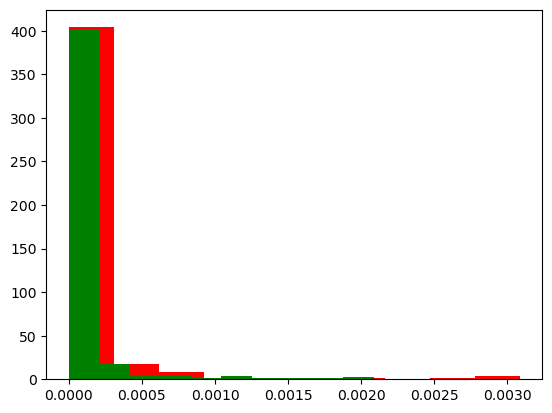

In [66]:
# plot absolute value of difference 
plt.hist(abs(merged_corr['new_ra_quality']), color='blue')
plt.hist(abs(merged_corr['old_ra_quality']), color='red')
plt.hist(abs(merged_corr['new_dec_quality']), color='orange')
plt.hist(abs(merged_corr['old_dec_quality']), color='green')

In [67]:
merged_corr[['new_ra_quality', 'old_ra_quality', 'new_dec_quality', 'old_dec_quality']].describe()

,new_ra_quality,old_ra_quality,new_dec_quality,old_dec_quality
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,1.622467e-04,1.622913e-04,1.173940e-04,1.173894e-04
std,3.644799e-04,3.644805e-04,2.668057e-04,2.668276e-04
min,5.365320e-07,5.301802e-07,1.274536e-09,3.472694e-08
25%,3.246943e-05,3.285521e-05,2.121505e-05,2.086690e-05
50%,7.023570e-05,7.009012e-05,4.931371e-05,4.909910e-05
75%,1.389991e-04,1.392122e-04,9.755459e-05,9.786499e-05
max,3.085562e-03,3.085459e-03,2.084773e-03,2.085274e-03


Text(0, 0.5, 'old')

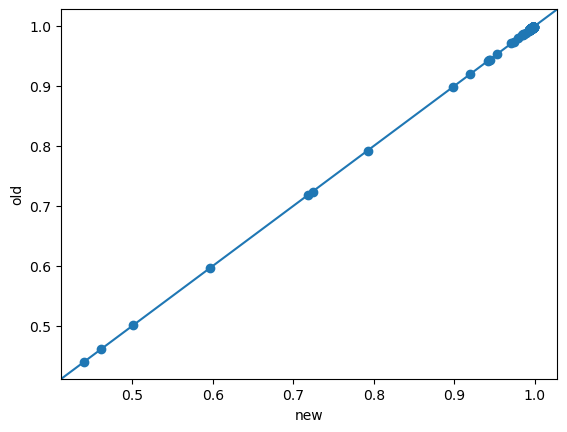

In [79]:
plt.scatter(merged_corr['match_weight_new'],merged_corr['match_weight_old'])
plt.axline((1,1),slope=1)
plt.xlabel('new')
plt.ylabel('old')

In [84]:
# checking orientation 
from pyarrow import parquet 

In [166]:
eclipse = 580

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
new_asp = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect2.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv")


In [149]:
og_aspect['roll'].mean()

226.19304634813972

Text(0, 0.5, 'roll')

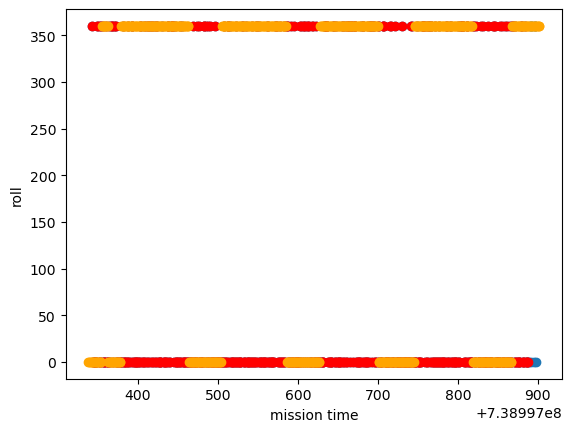

In [168]:
eclipse = 580

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect.csv")


asp['orientation'] = abs(asp['orientation']+np.where(asp['orientation']<0, 360, 0))

difference = asp['orientation'].median()-og_aspect['roll'].median()

if difference < -4 or difference > 4: 
    difference = 0 

og_aspect['diff'] = og_aspect['roll'] + difference

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(new_asp['time'],new_asp['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')


In [169]:
asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

asp.to_csv('/home/bekah/gPhoton2/test_data/aspect/00580_new_aspect_diff.csv')

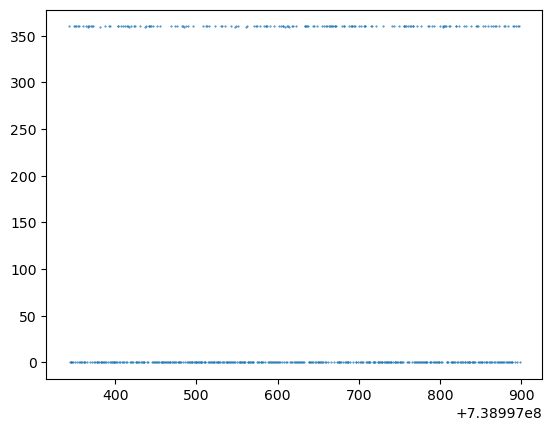

In [142]:
plt.scatter(asp['mission_time'],asp['orientation'],s=.2)

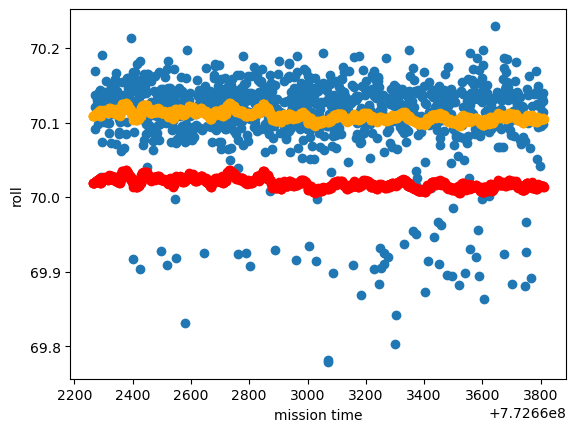

In [170]:
# 6268 

eclipse = 6268

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/06268_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

asp.to_csv('/home/bekah/gPhoton2/test_data/aspect/06268_new_aspect_diff.csv')

Text(0, 0.5, 'roll')

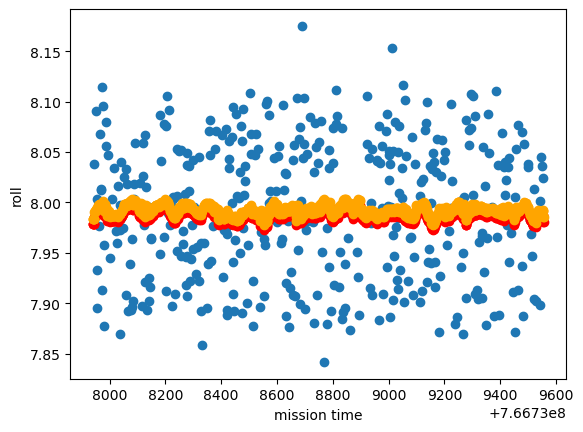

In [118]:

eclipse = 5267

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/05267_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

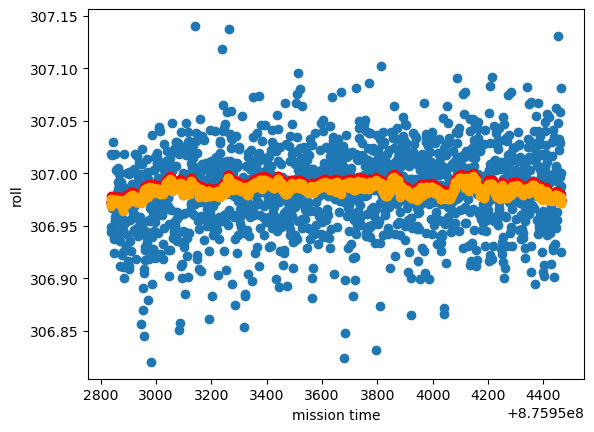

In [153]:

eclipse = 23725

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()
asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/23725_new_aspect.csv")

asp['orientation'] = abs(asp['orientation']+np.where(asp['orientation']<0, 360, 0))


difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']

og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

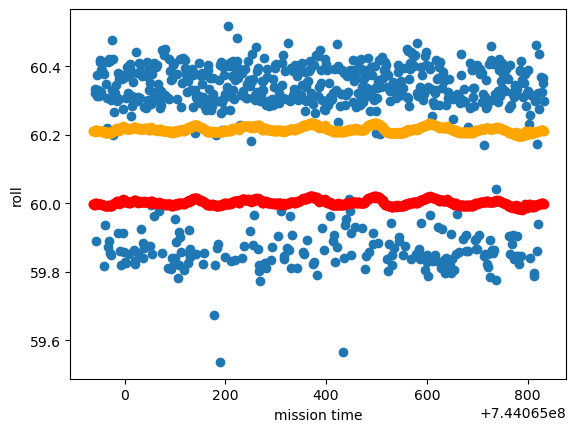

In [121]:

eclipse = 1436

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/01436_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

Text(0, 0.5, 'roll')

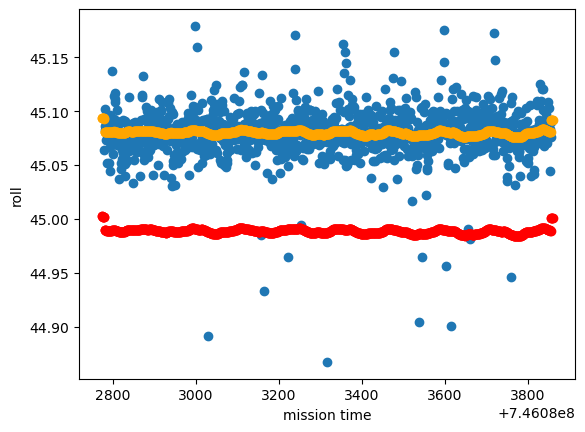

In [122]:

eclipse = 1777

og_aspect = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                                  filters=[('eclipse','==',eclipse)]).to_pandas()

asp = pd.read_csv("/home/bekah/gPhoton2/test_data/aspect/01777_new_aspect.csv")
difference = asp['orientation'].describe()['mean']-og_aspect['roll'].describe()['mean']
og_aspect['diff'] = og_aspect['roll'] + difference 

plt.scatter(asp['mission_time'],asp['orientation'])
plt.scatter(og_aspect['time'],og_aspect['roll'],color='red')
plt.scatter(og_aspect['time'],og_aspect['diff'],color='orange')

plt.xlabel('mission time')
plt.ylabel('roll')

In [159]:
asp = asp.join(og_aspect.set_index('time'), on='mission_time', rsuffix='_og')
asp.rename(columns={"orientation": "orientation_uncorrected", "diff": "orientation"})

,Unnamed: 0,ra,dec,roll,pixscale,ra_center,dec_center,logodds,time,frame_type,...,dec_og,roll_og,flags,orientation,eclipse_og,ra_og,dec_og,roll_og,flags_og,diff_og
0,0,4.365647,0.785823,-52.981545,1.125681,4.098938,1.155243,189.0,0.0,ref,...,1.155293,306.978437,81,306.975381,23725,4.099120,1.155293,306.978437,81,306.975381
1,1,3.989132,1.346842,-53.055740,1.124684,4.098819,1.154998,185.0,1.0,ref,...,1.155083,306.972224,0,306.969168,23725,4.098983,1.155083,306.972224,0,306.969168
2,2,3.946622,1.392268,-53.051578,1.123996,4.098525,1.154910,119.0,2.0,ref,...,1.154915,306.972577,0,306.969521,23725,4.098935,1.154915,306.972577,0,306.969521
3,3,4.360035,0.825374,-53.029130,1.125505,4.098873,1.154182,179.0,3.0,ref,...,1.154579,306.972870,0,306.969814,23725,4.098942,1.154579,306.972870,0,306.969814
4,4,3.967274,1.408522,-53.031444,1.124564,4.098714,1.154272,109.0,4.0,ref,...,1.154414,306.973253,0,306.970197,23725,4.099000,1.154414,306.973253,0,306.970197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,1625,3.870380,1.315423,-53.003890,1.123946,4.118679,1.160431,191.0,1625.0,ref,...,1.160186,306.975172,0,306.972116,23725,4.119069,1.160186,306.975172,0,306.972116
1625,1626,4.360033,0.825367,-53.075178,1.124868,4.118680,1.160779,165.0,1626.0,ref,...,1.160913,306.974892,0,306.971836,23725,4.119032,1.160913,306.974892,0,306.971836
1626,1627,4.440044,0.811222,-52.918638,1.124390,4.119034,1.161885,160.0,1627.0,ref,...,1.161611,306.974638,0,306.971582,23725,4.118863,1.161611,306.974638,0,306.971582
1627,1628,4.315554,0.788192,-53.012546,1.124235,4.118598,1.162363,134.0,1628.0,ref,...,1.162301,306.974327,0,306.971271,23725,4.118697,1.162301,306.974327,0,306.971271


TypeError: Image data of dtype object cannot be converted to float

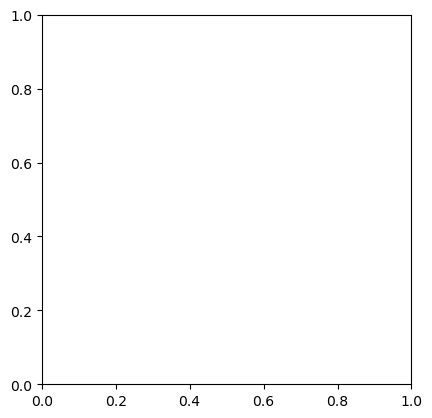

In [176]:
e68268 = fits.open("/home/bekah/gPhoton2/new_asp6268/e06268/e06268-nd-b00-ffull-image-r.fits")
plt.imshow(e68268[0].data)

In [217]:
# files 
solved = fits.open('/home/bekah/gPhoton2/og_asp_11604/e11604/e11604-nd-b00-ffull-image-r.wcs')
solved

In [218]:
solved[0].header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        292.281702577 / RA  of reference point                         
CRVAL2  =       -41.6060567923 / DEC of reference point                         
CRPIX1  =                 19

In [229]:
eclipse = 11604
new_corr = fits.open(f'/home/bekah/gPhoton2/new_asp11604/e11604/e11604-nd-b00-ffull-image-r.corr')
old_corr = fits.open(f'/home/bekah/gPhoton2/og_asp_11604/e11604/e11604-nd-b00-ffull-image-r.corr')
#old_corr = fits.open("/home/bekah/Downloads/corr.fits")

new_df=pd.DataFrame(np.array(new_corr[1].data).byteswap().newbyteorder())
old_df=pd.DataFrame(np.array(old_corr[1].data).byteswap().newbyteorder())

merged_corr = pd.merge(old_df, new_df, how='inner', on='index_ra', suffixes=('_old', '_new'))

# calculate diff between star and index location 
#merged_corr['old_ra_quality'] = abs(merged_corr['field_ra_old']-merged_corr['index_ra_old'])
merged_corr['old_dec_quality'] = abs(merged_corr['field_dec_old']-merged_corr['index_dec_old'])
#merged_corr['new_ra_quality'] = abs(merged_corr['field_ra_new']-merged_corr['index_ra_new'])
merged_corr['new_dec_quality'] = abs(merged_corr['field_dec_new']-merged_corr['index_dec_new'])
merged_corr['flux_diff'] = merged_corr['FLUX_new']-merged_corr['FLUX_old']

merged_corr

,field_x_old,field_y_old,field_ra_old,field_dec_old,index_x_old,index_y_old,index_ra,index_dec_old,index_id_old,field_id_old,...,index_y_new,index_dec_new,index_id_new,field_id_new,match_weight_new,FLUX_new,BACKGROUND_new,old_dec_quality,new_dec_quality,flux_diff
0,2172.641113,1637.308716,292.133799,-41.583392,2171.040008,1636.615677,292.134690,-41.583683,7,7,...,1602.702681,-41.583683,5,13,0.996752,12209.821289,3.327148,0.000291,0.000221,834.251953
1,2149.188721,1182.590942,292.146045,-41.772879,2147.449121,1182.534525,292.147017,-41.772905,21,15,...,1148.655252,-41.772905,21,22,0.997139,10678.929688,3.247070,0.000026,0.000035,1100.327148
2,914.653564,1692.627075,292.834321,-41.559873,913.972632,1692.092435,292.834701,-41.560095,43,17,...,1658.778424,-41.560095,38,8,0.998346,4897.444336,3.437500,0.000221,0.000235,853.835205
3,2114.430908,1784.470093,292.166469,-41.522151,2113.711618,1783.853465,292.166869,-41.522408,236,24,...,1749.955886,-41.522408,193,7,0.998544,4989.737793,3.337402,0.000258,0.000206,712.963379
4,968.737122,1301.106812,292.805193,-41.723122,968.268752,1300.843560,292.805455,-41.723231,60,25,...,1267.508308,-41.723231,48,16,0.998603,4244.010742,3.335449,0.000109,0.000138,719.369873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2551.972900,2470.783203,291.925295,-41.235536,2552.740916,2470.774406,291.924869,-41.235538,219,3394,...,2436.582747,-41.235538,178,3469,0.997803,61.591270,3.122520,0.000002,0.000043,17.042130
383,2771.179199,1758.902710,291.800953,-41.531510,2771.205032,1759.198486,291.800940,-41.531386,1138,3404,...,1724.998781,-41.531386,947,2890,0.998109,51.224903,3.062172,0.000123,0.000115,21.985720
384,689.322754,2288.503174,292.957716,-41.311085,689.338012,2288.929167,292.957706,-41.310907,51,3426,...,2255.697578,-41.310907,43,2631,0.998087,17.244217,3.397156,0.000177,0.000018,4.444387
385,2818.732666,2384.277344,291.777169,-41.270887,2818.768455,2384.440603,291.777150,-41.270819,292,3475,...,2350.134721,-41.270819,242,3581,0.997578,61.560078,1.173927,0.000068,0.000073,16.538464


In [226]:
merged_corr['field_x_old']-merged_corr['field_x_new']

0      -104.233887
1        -0.546631
2       224.125488
3     -1758.127869
4     -1039.049438
          ...     
196    1789.371277
197   -1703.141357
198    1475.523926
199    1586.075134
200    1804.623108
Length: 201, dtype: float64

Text(0.5, 1.0, 'old dec quality')

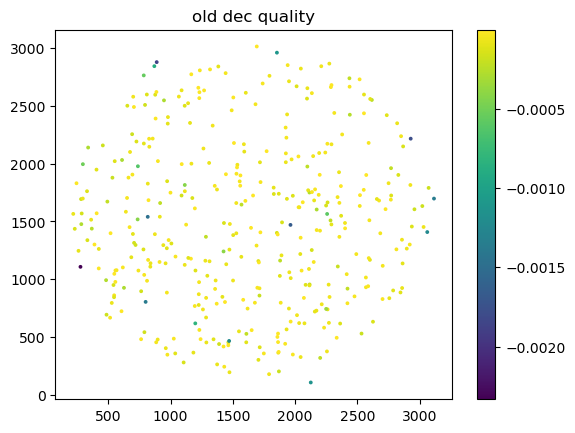

In [231]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['old_dec_quality'],s=3)

plt.colorbar()
plt.title('old dec quality')

Text(0.5, 1.0, 'new dec quality')

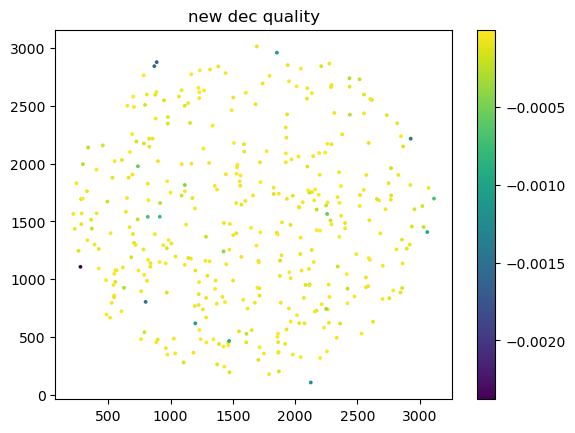

In [232]:
#plt.scatter(merged_corr['field_x_old'],merged_corr['field_y_old'],c=merged_corr['old_dec_quality'])
plt.scatter(merged_corr['field_x_new'],merged_corr['field_y_new'],c=-merged_corr['new_dec_quality'],s=3)

plt.colorbar()
plt.title('new dec quality')

In [ ]:
"field" are coordinates in your image -- "field_x" and "field_y" are detected star positions.  "field_ra", "field_dec" are "field_x", "field_y" converted to RA,Dec via the WCS.

"index" are coordinates from the reference catalog -- "index_ra", "index_dec" are reference star coordinates, while "index_x", "index_y" are those converted to pixels via the WCS.

cheers,
--dustin